In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import sys
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import gcsfs
%config InlineBackend.figure_format = 'retina'
fs = gcsfs.GCSFileSystem() # equivalent to fsspec.fs('gs')
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')

/tmp/ipykernel_1360/4064699263.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def po_t_of_refyear(da,threshold,refyear,dim):
    return da.where(da>da.sel(window=refyear).quantile(threshold,dim=dim))
            
def rolling_max(da,window_len,dim):
    return da.rolling({dim:window_len},center=True,min_periods=1).max()

def sum_num_extremes_pmonth(extremes):
    extremes_ = extremes.copy(deep=True) #boolean array (True or False joint extreme occurs on that day)
    if len(extremes.time.shape)>1:
        extremes_['time_in_window_idx'] = extremes_.time.dt.month.isel(window=0).values
    else:
        extremes_['time_in_window_idx'] = extremes_.time.dt.month.values
    num_extremes_pmonth = extremes_.rename({'time_in_window_idx':'month'}).groupby('month').sum()
    return num_extremes_pmonth        

In [3]:
max_lag = 0 #days
declus_window_len = 1 #days
threshold = .98 #quantile

output_yrs = np.arange(1960,2100,20)
window_len=40 #may need to increase? indicate settings in output folder?

ref_year = 2000 #period to to compute thresholds from

Load output:

In [4]:
#configure the CMIP6 input settings
var1 = 'sfcWind'
var2 = 'pr'
domain = 'europe' #'europe' or 'tgs'

var1_dir = 'leap-persistent/timh37/CMIP6/timeseries/'+var1+'_'+domain
var2_dir = 'leap-persistent/timh37/CMIP6/timeseries/'+var2+'_'+domain

if domain == 'tgs':
    input_is_gridded = False
elif domain == 'europe':
    input_is_gridded = True

In [5]:
models_var1 = [k.split('/')[-1] for k in fs.ls(var1_dir)]
models_var2 = [k.split('/')[-1] for k in fs.ls(var2_dir)]
source_ids = sorted(list(set(models_var1) & set(models_var2))) #intersection of models

for source_id in ['GFDL-CM4']:#[k for k in source_ids if ~k.startswith('.')]: #loop over models
  
    var1_model_path = os.path.join(var1_dir,source_id)
    var2_model_path = os.path.join(var2_dir,source_id)
    
    #sfcWind_exps = [s.split('_')[-1][0:-3] for s in os.listdir(sfcWind_path) if s.startswith('.')==False]
    #pr_exps = [s.split('_')[-1][0:-3] for s in os.listdir(pr_path) if s.startswith('.')==False]
    
    #get experiment_id's
    var1_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var1_model_path) if s.startswith('.')==False] 
    var2_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var2_model_path) if s.startswith('.')==False]
    experiment_ids = list(set(var1_exps) & set(var2_exps))

    for experiment_id in experiment_ids: #loop over experiments
        #load data:
        fn = fnmatch.filter(fs.ls(var1_model_path),'*'+experiment_id+'*')[0]
        fn = fn.split('/')[-1]
        print('Processing file: '+fn)
        if input_is_gridded==False:
            var1_var2_data = xr.open_mfdataset((os.path.join('gs://',var1_model_path,fn),os.path.join('gs://',var2_model_path,fn)),engine='zarr',chunks={'member_id':1,'time':100000})
        else:
            #sfcWind_pr = xr.open_mfdataset((os.path.join(sfcWind_path,fn),os.path.join(pr_path,fn)),chunks={'member_id':1,'time':100000,'longitude':3})#.sel(longitude=np.arange(-25,11))
            var1_var2_data = xr.open_mfdataset((os.path.join('gs://',var1_model_path,fn),os.path.join('gs://',var2_model_path,fn)),engine='zarr',chunks={'member_id':1,'time':100000,'longitude':5})
 
        #generate output paths
        #model_path = os.path.join('/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d_ref2000',sfcWind_pr.source_id)
        output_path = '/home/jovyan/CMIP6cf/output/num_extremes/'+var1+'_'+var2+'_'+var1_dir.split('_')[-1]+'/'+str(window_len)+'yr_'+str(threshold).replace('0.','p')+'_lag'+str(max_lag)+'d_declus'+str(declus_window_len)+'d_ref'+str(ref_year)
        output_model_path = os.path.join(output_path,var1_var2_data.source_id)
        output_fn = os.path.join(output_model_path,fn.replace('.zarr','.nc'))

        #construct time window indices
        if len(np.unique(var1_var2_data.time.resample(time='1Y').count()))>1: #remove leap days so that each computation window has the same length
            with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                var1_var2_data = var1_var2_data.sel(time=~((var1_var2_data.time.dt.month == 2) & (var1_var2_data.time.dt.day == 29))) #^probably (hopefully) only has a small effect on the results
        
        days_in_year = int(var1_var2_data.time.resample(time='1Y').count()[0])
        
        if window_len%2 !=0: #odd
            window_start_idx = days_in_year*(output_yrs-1850-int(np.floor(window_len/2)))
            first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
        else: #even
            window_start_idx = days_in_year*(output_yrs-1850-int(window_len/2)+1)
            first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
        
        if np.max(first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:])>=len(var1_var2_data.time): #if window exceeds simulation length
            continue #skip
            #raise Exception('Windows exceed simulation length.')
            
        window_idx = xr.DataArray( #indices of windows
            data=first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:],
            dims=["time_in_window_idx","window"],
            coords=dict(
                time_in_window_idx=first_window_idx,
                window=output_yrs
            ),
        )
        
        
            
        for m,member in tqdm(enumerate(var1_var2_data.member_id)): #loop over members of each model to compute the dependence
        
            var1_var2_data_mem = var1_var2_data.sel(member_id=member)
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                var1_var2_data_wdws = var1_var2_data_mem.isel(time=window_idx) #select data in user-defined time windows
            
            data_is_complete = np.isfinite(var1_var2_data_wdws[var1]).all(dim='time_in_window_idx') * np.isfinite(var1_var2_data_wdws[var2]).all(dim='time_in_window_idx') #check data-completeness in each window

            #derive peaks
            var1_peaks = po_t_of_refyear(var1_var2_data_wdws[var1],threshold,ref_year,dim='time_in_window_idx')
            var2_peaks = po_t_of_refyear(var1_var2_data_wdws[var2],threshold,ref_year,dim='time_in_window_idx')
            
            var1_peaks_declustered = var1_peaks.where(var1_peaks==var1_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))
            var2_peaks_declustered = var2_peaks.where(var2_peaks==var2_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))
            
            '''
            #determine joint extremes within 'max_lag' lag from eachother
            joint_extremes = np.isfinite((rolling_max(var2_peaks_declustered,max_lag*2+1,dim='time_in_window_idx')*var1_peaks_declustered)) #previously: 'co_occurring'
            
            #generate output dataset for current member
            num_extremes_mem = sum_num_extremes_pmonth(joint_extremes).to_dataset(name='num_joint_extremes')
            num_extremes_mem['num_'+var1+'_extremes'] = sum_num_extremes_pmonth(np.isfinite(var1_peaks_declustered))
            num_extremes_mem['num_'+var2+'_extremes'] = sum_num_extremes_pmonth(np.isfinite(var2_peaks_declustered))
            '''
            

Processing file: GFDL-CM4_gr1_day_ssp245.zarr


0it [00:00, ?it/s]

Processing file: GFDL-CM4_gr1_day_ssp585.zarr


0it [00:00, ?it/s]

In [6]:
sample_data = var1_var2_data_wdws.sel(longitude=5,latitude=50,method='nearest').load()

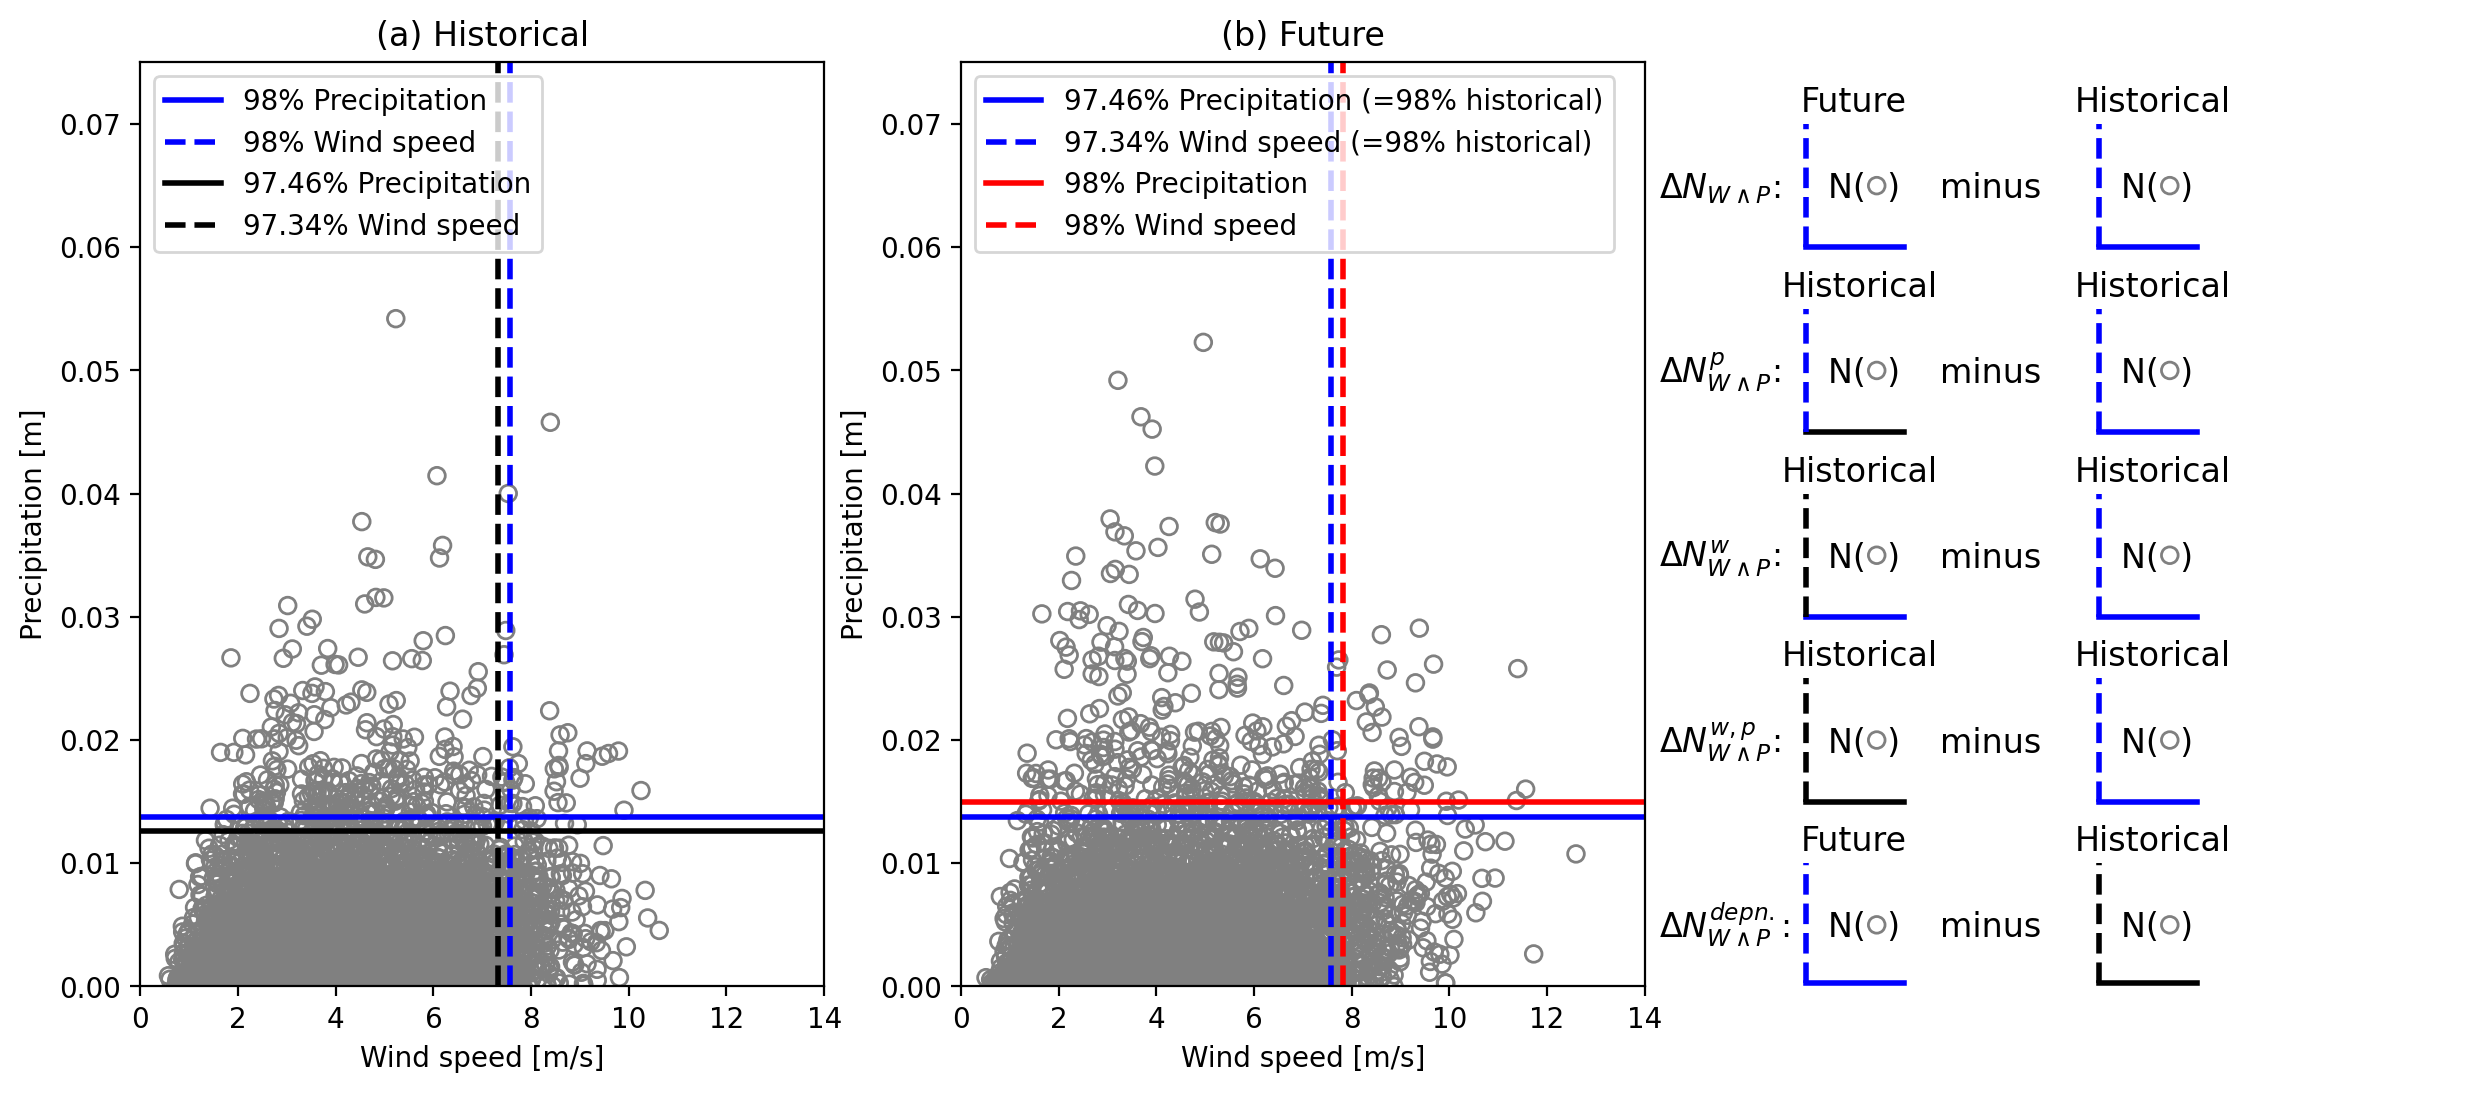

In [8]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(1,3)
#gs.update(wspace=.4,hspace=.1)

ax = plt.subplot(gs[0,0])
ax.scatter(sample_data.sel(window=2000)[var1],sample_data.sel(window=2000)[var2],edgecolor='grey',facecolor='None')
ax.set_ylabel('Precipitation [m]')
ax.set_xlabel('Wind speed [m/s]')
ax.axhline(y=np.quantile(sample_data.sel(window=2000)[var2],q=.98),color='blue',linestyle='solid',linewidth=2,label='98% Precipitation')
ax.axvline(x=np.quantile(sample_data.sel(window=2000)[var1],q=.98),color='blue',linestyle='dashed',linewidth=2,label='98% Wind speed')

#fut_eqv
eqv_pct_var1 = 1-np.sum(sample_data.sel(window=2080)[var1]>np.quantile(sample_data.sel(window=2000)[var1],q=.98))/len(sample_data.sel(window=2080)[var1])
eqv_pct_var2 = 1-np.sum(sample_data.sel(window=2080)[var2]>np.quantile(sample_data.sel(window=2000)[var2],q=.98))/len(sample_data.sel(window=2080)[var2])

ax.axhline(y=np.quantile(sample_data.sel(window=2000)[var2],q=eqv_pct_var2),color='black',linestyle='solid',linewidth=2,label='{0:.2f}'.format(100*eqv_pct_var2.values)+'% Precipitation')
ax.axvline(x=np.quantile(sample_data.sel(window=2000)[var1],q=eqv_pct_var1),color='black',linestyle='dashed',linewidth=2,label='{0:.2f}'.format(100*eqv_pct_var1.values)+'% Wind speed')

ax.set_ylim([0,0.075])
ax.set_xlim([0,14])
ax.legend(loc='upper left')
ax.set_title('(a) Historical')

ax = plt.subplot(gs[0,1])
ax.scatter(sample_data.sel(window=2080)[var1],sample_data.sel(window=2080)[var2],edgecolor='grey',facecolor='None')
ax.set_ylabel('Precipitation [m]')
ax.set_xlabel('Wind speed [m/s]')
ax.axhline(y=np.quantile(sample_data.sel(window=2000)[var2],q=.98),color='blue',linestyle='solid',linewidth=2,label='{0:.2f}'.format(100*eqv_pct_var2.values)+'% Precipitation (=98% historical)')
ax.axvline(x=np.quantile(sample_data.sel(window=2000)[var1],q=.98),color='blue',linestyle='dashed',linewidth=2,label='{0:.2f}'.format(100*eqv_pct_var1.values)+'% Wind speed (=98% historical)')

ax.axhline(y=np.quantile(sample_data.sel(window=2080)[var2],q=.98),color='red',linestyle='solid',linewidth=2,label='98% Precipitation')
ax.axvline(x=np.quantile(sample_data.sel(window=2080)[var1],q=.98),color='red',linestyle='dashed',linewidth=2,label='98% Wind speed')
ax.legend(loc='upper left')

ax.set_ylim([0,0.075])
ax.set_xlim([0,14])
ax.set_title('(b) Future')

ax = plt.subplot(gs[0,2])
#dN_WP
ax.plot([0.5,2.5],[0.06,0.06],color='blue',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.06,0.07],color='blue',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.06,0.06],color='blue',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.06,0.07],color='blue',linestyle='dashed',linewidth=2)


ax.text(-2.5,0.064,'$\Delta N_{W \wedge P}$:',fontsize=12)
ax.text(.4,0.071,'Future',fontsize=12)
ax.text(6,0.071,'Historical',fontsize=12)

ax.text(3.25,0.064,'minus',fontsize=12)

ax.text(6.95,0.064,'N(  )',fontsize=12)
ax.scatter([7.95],[0.065],edgecolor='grey',facecolor='None')
ax.text(.95,0.064,'N(  )',fontsize=12)
ax.scatter([1.95],[0.065],edgecolor='grey',facecolor='None')

#dN_WP
ax.plot([0.5,2.5],[0.045,0.045],color='black',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.045,0.055],color='blue',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.045,0.045],color='blue',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.045,0.055],color='blue',linestyle='dashed',linewidth=2)

ax.text(0,0.056,'Historical',fontsize=12)
ax.text(6,0.056,'Historical',fontsize=12)
ax.text(-2.5,0.049,'$\Delta N_{W \wedge P}^{p}$:',fontsize=12)
ax.text(3.25,0.049,'minus',fontsize=12)

ax.text(6.95,0.049,'N(  )',fontsize=12)
ax.scatter([7.95],[0.05],edgecolor='grey',facecolor='None')
ax.text(.95,0.049,'N(  )',fontsize=12)
ax.scatter([1.95],[0.05],edgecolor='grey',facecolor='None')


#
ax.plot([0.5,2.5],[0.03,0.03],color='blue',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.03,0.04],color='black',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.03,0.03],color='blue',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.03,0.04],color='blue',linestyle='dashed',linewidth=2)

ax.text(0,0.041,'Historical',fontsize=12)
ax.text(6,0.041,'Historical',fontsize=12)
ax.text(-2.5,0.034,'$\Delta N_{W \wedge P}^{w}$:',fontsize=12)
ax.text(3.25,0.034,'minus',fontsize=12)

ax.text(6.95,0.034,'N(  )',fontsize=12)
ax.scatter([7.95],[0.035],edgecolor='grey',facecolor='None')
ax.text(.95,0.034,'N(  )',fontsize=12)
ax.scatter([1.95],[0.035],edgecolor='grey',facecolor='None')


#
ax.plot([0.5,2.5],[0.015,0.015],color='black',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.015,0.025],color='black',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.015,0.015],color='blue',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.015,0.025],color='blue',linestyle='dashed',linewidth=2)

ax.text(0,0.026,'Historical',fontsize=12)
ax.text(6,0.026,'Historical',fontsize=12)
ax.text(-2.5,0.019,'$\Delta N_{W \wedge P}^{w,p}$:',fontsize=12)
ax.text(3.25,0.019,'minus',fontsize=12)


ax.text(6.95,0.019,'N(  )',fontsize=12)
ax.scatter([7.95],[0.02],edgecolor='grey',facecolor='None')
ax.text(.95,0.019,'N(  )',fontsize=12)
ax.scatter([1.95],[0.02],edgecolor='grey',facecolor='None')


#
ax.plot([0.5,2.5],[0.0003,0.0003],color='blue',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.0003,0.01],color='blue',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.0003,0.0003],color='black',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.0003,0.01],color='black',linestyle='dashed',linewidth=2)

ax.text(-2.5,0.004,'$\Delta N_{W \wedge P}^{depn.}$:',fontsize=12)
ax.text(.4,0.011,'Future',fontsize=12)
ax.text(6,0.011,'Historical',fontsize=12)
ax.text(3.25,0.004,'minus',fontsize=12)


ax.text(6.95,0.004,'N(  )',fontsize=12)
ax.scatter([7.95],[0.005],edgecolor='grey',facecolor='None')
ax.text(.95,0.004,'N(  )',fontsize=12)
ax.scatter([1.95],[0.005],edgecolor='grey',facecolor='None')


ax.set_ylim([0,0.075])
ax.set_xlim([0,14])
ax.set_yticks([])
ax.set_xticks([])
ax.spines[['right', 'top','bottom','left']].set_visible(False)

fig.savefig('Figures/decomp_schematic.pdf',format='pdf',dpi=300,bbox_inches='tight')


Some plots for presentation purposes:

"\nax = plt.subplot(gs[0,2])\n#dN_WP\nax.plot([0.5,2.5],[0.06,0.06],color='blue',linestyle='solid',linewidth=2)\nax.plot([0.5,0.5],[0.06,0.07],color='blue',linestyle='dashed',linewidth=2)\n\nax.plot([6.5,8.5],[0.06,0.06],color='blue',linestyle='solid',linewidth=2)\nax.plot([6.5,6.5],[0.06,0.07],color='blue',linestyle='dashed',linewidth=2)\n\n\nax.text(-2.5,0.064,'$\\Delta N_{W \\wedge P}$:',fontsize=12)\nax.text(.4,0.071,'Future',fontsize=12)\nax.text(6,0.071,'Historical',fontsize=12)\n\nax.text(3.25,0.064,'minus',fontsize=12)\n\nax.text(6.95,0.064,'N(  )',fontsize=12)\nax.scatter([7.95],[0.065],edgecolor='grey',facecolor='None')\nax.text(.95,0.064,'N(  )',fontsize=12)\nax.scatter([1.95],[0.065],edgecolor='grey',facecolor='None')\n\n#dN_WP\nax.plot([0.5,2.5],[0.045,0.045],color='black',linestyle='solid',linewidth=2)\nax.plot([0.5,0.5],[0.045,0.055],color='blue',linestyle='dashed',linewidth=2)\n\nax.plot([6.5,8.5],[0.045,0.045],color='blue',linestyle='solid',linewidth=2)\nax.plot([6.5,6

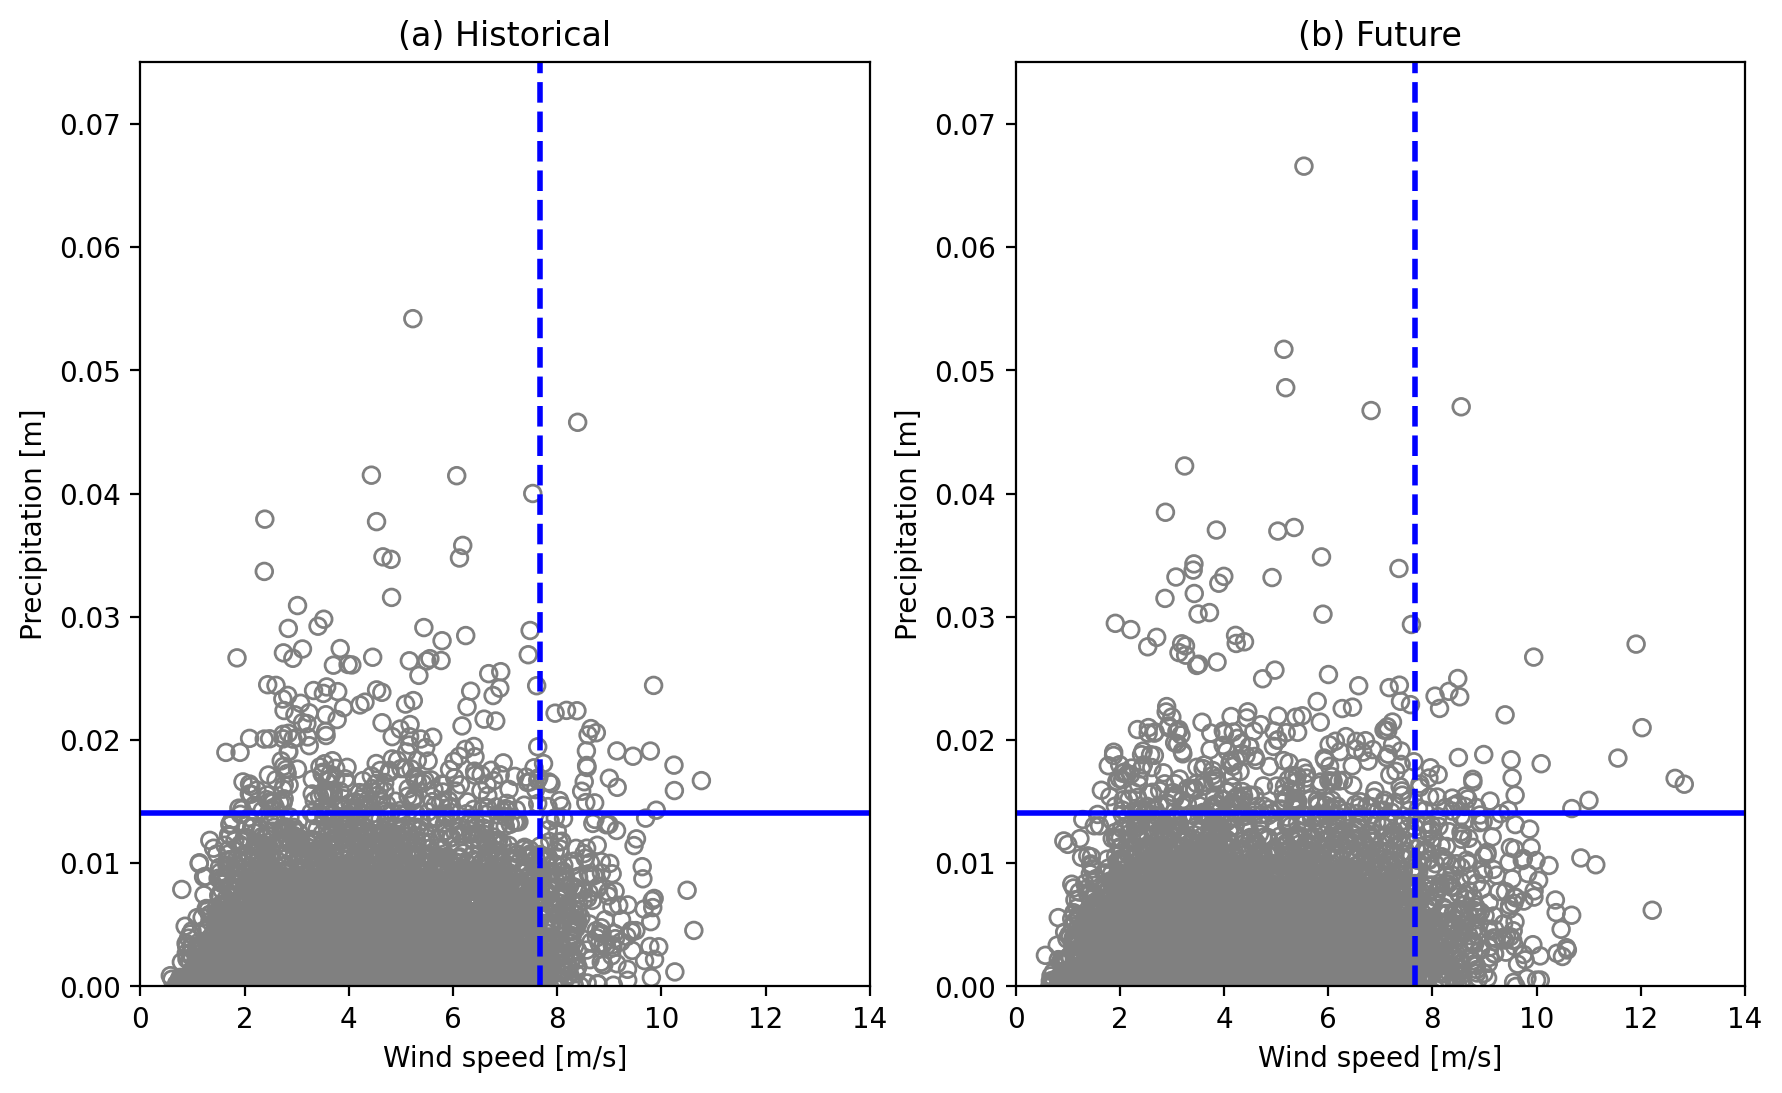

In [14]:
fig=plt.figure(figsize=(16,6)) #generate figure  
gs = fig.add_gridspec(1,3)
#gs.update(wspace=.4,hspace=.1)

ax = plt.subplot(gs[0,0])
ax.scatter(sample_data.sel(window=2000)[var1],sample_data.sel(window=2000)[var2],edgecolor='grey',facecolor='None')
ax.set_ylabel('Precipitation [m]')
ax.set_xlabel('Wind speed [m/s]')
ax.axhline(y=np.quantile(sample_data.sel(window=2000)[var2],q=.98),color='blue',linestyle='solid',linewidth=2,label='98% Precipitation')
ax.axvline(x=np.quantile(sample_data.sel(window=2000)[var1],q=.98),color='blue',linestyle='dashed',linewidth=2,label='98% Wind speed')

#fut_eqv
eqv_pct_var1 = 1-np.sum(sample_data.sel(window=2080)[var1]>np.quantile(sample_data.sel(window=2000)[var1],q=.98))/len(sample_data.sel(window=2080)[var1])
eqv_pct_var2 = 1-np.sum(sample_data.sel(window=2080)[var2]>np.quantile(sample_data.sel(window=2000)[var2],q=.98))/len(sample_data.sel(window=2080)[var2])

#ax.axhline(y=np.quantile(sample_data.sel(window=2000)[var2],q=eqv_pct_var2),color='black',linestyle='solid',linewidth=2,label='{0:.2f}'.format(100*eqv_pct_var2.values)+'% Precipitation')
#ax.axvline(x=np.quantile(sample_data.sel(window=2000)[var1],q=eqv_pct_var1),color='black',linestyle='dashed',linewidth=2,label='{0:.2f}'.format(100*eqv_pct_var1.values)+'% Wind speed')

ax.set_ylim([0,0.075])
ax.set_xlim([0,14])
#ax.legend(loc='upper left')
ax.set_title('(a) Historical')

ax = plt.subplot(gs[0,1])
ax.scatter(sample_data.sel(window=2080)[var1],sample_data.sel(window=2080)[var2],edgecolor='grey',facecolor='None')
ax.set_ylabel('Precipitation [m]')
ax.set_xlabel('Wind speed [m/s]')
ax.axhline(y=np.quantile(sample_data.sel(window=2000)[var2],q=.98),color='blue',linestyle='solid',linewidth=2,label='{0:.2f}'.format(100*eqv_pct_var2.values)+'% Precipitation (=98% historical)')
ax.axvline(x=np.quantile(sample_data.sel(window=2000)[var1],q=.98),color='blue',linestyle='dashed',linewidth=2,label='{0:.2f}'.format(100*eqv_pct_var1.values)+'% Wind speed (=98% historical)')

#ax.axhline(y=np.quantile(sample_data.sel(window=2080)[var2],q=.98),color='red',linestyle='solid',linewidth=2,label='98% Precipitation')
#ax.axvline(x=np.quantile(sample_data.sel(window=2080)[var1],q=.98),color='red',linestyle='dashed',linewidth=2,label='98% Wind speed')
#ax.legend(loc='upper left')

ax.set_ylim([0,0.075])
ax.set_xlim([0,14])
ax.set_title('(b) Future')
'''
ax = plt.subplot(gs[0,2])
#dN_WP
ax.plot([0.5,2.5],[0.06,0.06],color='blue',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.06,0.07],color='blue',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.06,0.06],color='blue',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.06,0.07],color='blue',linestyle='dashed',linewidth=2)


ax.text(-2.5,0.064,'$\Delta N_{W \wedge P}$:',fontsize=12)
ax.text(.4,0.071,'Future',fontsize=12)
ax.text(6,0.071,'Historical',fontsize=12)

ax.text(3.25,0.064,'minus',fontsize=12)

ax.text(6.95,0.064,'N(  )',fontsize=12)
ax.scatter([7.95],[0.065],edgecolor='grey',facecolor='None')
ax.text(.95,0.064,'N(  )',fontsize=12)
ax.scatter([1.95],[0.065],edgecolor='grey',facecolor='None')

#dN_WP
ax.plot([0.5,2.5],[0.045,0.045],color='black',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.045,0.055],color='blue',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.045,0.045],color='blue',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.045,0.055],color='blue',linestyle='dashed',linewidth=2)

ax.text(0,0.056,'Historical',fontsize=12)
ax.text(6,0.056,'Historical',fontsize=12)
ax.text(-2.5,0.049,'$\Delta N_{W \wedge P}^{p}$:',fontsize=12)
ax.text(3.25,0.049,'minus',fontsize=12)

ax.text(6.95,0.049,'N(  )',fontsize=12)
ax.scatter([7.95],[0.05],edgecolor='grey',facecolor='None')
ax.text(.95,0.049,'N(  )',fontsize=12)
ax.scatter([1.95],[0.05],edgecolor='grey',facecolor='None')


#
ax.plot([0.5,2.5],[0.03,0.03],color='blue',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.03,0.04],color='black',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.03,0.03],color='blue',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.03,0.04],color='blue',linestyle='dashed',linewidth=2)

ax.text(0,0.041,'Historical',fontsize=12)
ax.text(6,0.041,'Historical',fontsize=12)
ax.text(-2.5,0.034,'$\Delta N_{W \wedge P}^{w}$:',fontsize=12)
ax.text(3.25,0.034,'minus',fontsize=12)

ax.text(6.95,0.034,'N(  )',fontsize=12)
ax.scatter([7.95],[0.035],edgecolor='grey',facecolor='None')
ax.text(.95,0.034,'N(  )',fontsize=12)
ax.scatter([1.95],[0.035],edgecolor='grey',facecolor='None')


#
ax.plot([0.5,2.5],[0.015,0.015],color='black',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.015,0.025],color='black',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.015,0.015],color='blue',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.015,0.025],color='blue',linestyle='dashed',linewidth=2)

ax.text(0,0.026,'Historical',fontsize=12)
ax.text(6,0.026,'Historical',fontsize=12)
ax.text(-2.5,0.019,'$\Delta N_{W \wedge P}^{w,p}$:',fontsize=12)
ax.text(3.25,0.019,'minus',fontsize=12)


ax.text(6.95,0.019,'N(  )',fontsize=12)
ax.scatter([7.95],[0.02],edgecolor='grey',facecolor='None')
ax.text(.95,0.019,'N(  )',fontsize=12)
ax.scatter([1.95],[0.02],edgecolor='grey',facecolor='None')


#
ax.plot([0.5,2.5],[0.0003,0.0003],color='blue',linestyle='solid',linewidth=2)
ax.plot([0.5,0.5],[0.0003,0.01],color='blue',linestyle='dashed',linewidth=2)

ax.plot([6.5,8.5],[0.0003,0.0003],color='black',linestyle='solid',linewidth=2)
ax.plot([6.5,6.5],[0.0003,0.01],color='black',linestyle='dashed',linewidth=2)

ax.text(-2.5,0.004,'$\Delta N_{W \wedge P}^{depn.}$:',fontsize=12)
ax.text(.4,0.011,'Future',fontsize=12)
ax.text(6,0.011,'Historical',fontsize=12)
ax.text(3.25,0.004,'minus',fontsize=12)


ax.text(6.95,0.004,'N(  )',fontsize=12)
ax.scatter([7.95],[0.005],edgecolor='grey',facecolor='None')
ax.text(.95,0.004,'N(  )',fontsize=12)
ax.scatter([1.95],[0.005],edgecolor='grey',facecolor='None')


ax.set_ylim([0,0.075])
ax.set_xlim([0,14])
ax.set_yticks([])
ax.set_xticks([])
ax.spines[['right', 'top','bottom','left']].set_visible(False)
'''